# Object orientation classification

Objective : Find the angle between the positions of an object when rotated.

Dataset from: http://campar.in.tum.de/personal/slavcheva/3d-printed-dataset/index.html

In [1]:
import os
import glob
import numpy as np
import skimage.io
from skimage.transform import resize
import sklearn.model_selection
from tensorflow.keras.models import Model

from sklearn.utils import shuffle

from tensorflow import keras

import matplotlib.pyplot as plt

#### Functions for image manipulation - crop, resize images

In [2]:
def read_images(img_files):
    out_arr = []
    for file in img_files:
        img = skimage.io.imread(file)
        out_arr.append(img)
    out_arr = np.array(out_arr)
    return out_arr

def crop_images(arr):
    img_crp = []
    for i in range(len(arr)):
        img_crp.append(skimage.util.crop(arr[i],((190,90),(120,140),(0,0))))
    img_crp = np.array(img_crp)
    return img_crp


def resize_images(arr):
    rs_img = []
    for img in range(len(arr)):
        rs_img.append(resize(arr[img],(100,70)))
    rs_img = np.array(rs_img)
    return rs_img

#### Functions to plot accuracy and loss

In [3]:
def plot_acc(hist):
    fig = plt.figure()
    plt.suptitle('Accuracy vs epochs')
    plt.plot(hist.history['accuracy'], label='Trianing accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
    plt.legend()

def plot_loss(hist):
    fig = plt.figure()
    plt.suptitle('Loss vs epochs')
    plt.plot(hist.history['loss'], label='Trianing loss')
    plt.plot(hist.history['val_loss'], label='Validation loss')
    plt.legend()
    
def plot_mse(hist):
    fig = plt.figure()
    plt.suptitle('MSE vs epochs')
    plt.plot(hist.history['mse'], label='Trianing MSE')
    plt.plot(hist.history['val_mse'], label='Validation MSE')
    plt.legend()

## Read image files

In [4]:
image_files = sorted(glob.glob('Synthetic_Leopard_Circle/*.png'))

In [5]:
images = read_images(image_files)
print('Number of images read:', len(images))
print('Shape of images read:', images.shape)

Number of images read: 120
Shape of images read: (120, 480, 640, 3)


# 2. Data Preparation

### Process images

In [6]:
# Crop images
images_crp = crop_images(images)
print('Images cropped to size: {}x{}'.format(images_crp[0].shape[0], images_crp[1].shape[1]) )

Images cropped to size: 200x380


In [7]:
# Helper function to normalize data in the range [-1,1]
def normalize(x):
    return (x.astype(float) - 128)/128

images_norm = normalize(images_crp)

In [8]:
# Resize images
image_trans = resize_images(images_norm)
print('Images resized to: {}x{}'.format(image_trans[0].shape[0], image_trans[1].shape[1]))

Images resized to: 100x70


### Randomly split 120 images for train, validation and test (90:10:20) which will be used as start positions

In [9]:
np.random.seed(42)
index = np.array(range(0,120))

shuffle_index = shuffle(index)

train_idx = shuffle_index[:90]
val_idx = shuffle_index[90:100]
test_idx = shuffle_index[100:120]

print('No. of start position images in TRAIN:',len(train_idx))
print('No. of start position images in VALIDATION:',len(val_idx))
print('No. of start position images in TEST:',len(test_idx))

No. of start position images in TRAIN: 90
No. of start position images in VALIDATION: 10
No. of start position images in TEST: 20


### Create image pairs and labels for images in train, validation, test set with an angle offset -45 to +45

In [10]:
def create_pairs_labels(start_positions,img_arr):
    pairs = []
    labels = []
    img_offset_values = np.array(range(-15,16))
    for idx in (start_positions):
        for j in range(len(img_offset_values)):
            img1 = img_arr[idx]
            j2 = img_offset_values[j]
            i2 = idx+j2
            if i2 >= 120:
                i2 = i2 % 120
            img2 = img_arr[(i2)]
            pairs.append(np.concatenate((img1, img2), axis=2))
            labels.append(j2*3)
    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels

#### Image pairs created are only used for parts 3(Classification) and 4(Regressor)

In [11]:
X_train, Y_train = create_pairs_labels(train_idx, image_trans)
X_val, Y_val = create_pairs_labels(val_idx, image_trans)
X_test, Y_test = create_pairs_labels(test_idx, image_trans)

print('Total number of pairs:')
print('Train :', len(X_train))
print('Validation:',len(X_val))
print('Tets:',len(X_test))
print('\n')
print('Shape of image pairs:')
print('Train:',X_train.shape)
print('Validation:',X_val.shape)
print('Test:', X_test.shape)

Total number of pairs:
Train : 2790
Validation: 310
Tets: 620


Shape of image pairs:
Train: (2790, 100, 70, 6)
Validation: (310, 100, 70, 6)
Test: (620, 100, 70, 6)


# 3. Classification Network

#### Function for one hot encoding of labels

In [12]:
def one_hot_encode(label_arr):
    one_hot = np.zeros((len(label_arr), 31))
    lab_ref = np.array(range(-15,16))*3
    for el in range(len(label_arr)):
        ind = np.where(lab_ref == label_arr[el])
        one_hot[el,ind] = 1
    return one_hot

#### Convert labels to one hot encoded labels

In [13]:
Y_train_oh = one_hot_encode(Y_train)
Y_val_oh = one_hot_encode(Y_val)
Y_test_oh = one_hot_encode(Y_test)

print('Shape of one hot encoded labels:')
print('Train set labels:',Y_train_oh.shape)
print('Validation set labels:',Y_val_oh.shape)
print('Test set labels:',Y_test_oh.shape)

Shape of one hot encoded labels:
Train set labels: (2790, 31)
Validation set labels: (310, 31)
Test set labels: (620, 31)


### Classification CNN model

In [14]:
classif_model = keras.Sequential([
    keras.layers.Conv2D(16, (2,2), activation='relu', padding='same', input_shape=(100,70,6)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (2,2), activation='relu', padding='same'), 
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(31, activation='softmax'),
])

classif_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 70, 16)       400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 35, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 35, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13600)             0         
_________________________________________________________________
dropout (Dropout)            (None, 13600)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               2

In [15]:
classif_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

classif_model_history = classif_model.fit(X_train, Y_train_oh, epochs=60, batch_size=20,
                                          validation_data=(X_val, Y_val_oh))

Epoch 1/60
140/140 [==============================] - 6s 40ms/step - loss: 3.5902 - accuracy: 0.0410 - val_loss: 2.9327 - val_accuracy: 0.1226
Epoch 2/60
140/140 [==============================] - 5s 38ms/step - loss: 2.7233 - accuracy: 0.1575 - val_loss: 2.1036 - val_accuracy: 0.3000
Epoch 3/60
140/140 [==============================] - 5s 39ms/step - loss: 1.9660 - accuracy: 0.2964 - val_loss: 1.7949 - val_accuracy: 0.3548
Epoch 4/60
140/140 [==============================] - 6s 40ms/step - loss: 1.6358 - accuracy: 0.3793 - val_loss: 1.4435 - val_accuracy: 0.4645
Epoch 5/60
140/140 [==============================] - 6s 40ms/step - loss: 1.4072 - accuracy: 0.4319 - val_loss: 1.2521 - val_accuracy: 0.5226
Epoch 6/60
140/140 [==============================] - 6s 40ms/step - loss: 1.2196 - accuracy: 0.5065 - val_loss: 1.2095 - val_accuracy: 0.5065
Epoch 7/60
140/140 [==============================] - 6s 39ms/step - loss: 1.1013 - accuracy: 0.5395 - val_loss: 1.0791 - val_accuracy: 0.5806

Epoch 58/60
140/140 [==============================] - 6s 45ms/step - loss: 0.2679 - accuracy: 0.8980 - val_loss: 0.3320 - val_accuracy: 0.8774
Epoch 59/60
140/140 [==============================] - 6s 42ms/step - loss: 0.2253 - accuracy: 0.9145 - val_loss: 0.3131 - val_accuracy: 0.8677
Epoch 60/60
140/140 [==============================] - 7s 47ms/step - loss: 0.2146 - accuracy: 0.9160 - val_loss: 0.6422 - val_accuracy: 0.7387


#### Learning curve

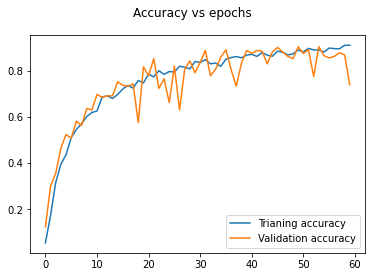

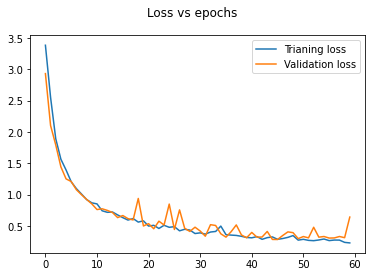

In [16]:
plot_acc(classif_model_history)
plot_loss(classif_model_history)

In [17]:
classif_test_loss, classif_test_acc = classif_model.evaluate(X_test, Y_test_oh)

20/20 [==============================] - 0s 14ms/step - loss: 0.6183 - accuracy: 0.7403


In [18]:
print('Accuracies:')
print('Train : {:.2f}%'.format((classif_model_history.history.get('accuracy')[-1])*100))
print('Validation : {:.2f}%'.format((classif_model_history.history.get('val_accuracy')[-1])*100))
print('Test : {:.2f}%'.format(classif_test_acc*100))

Accuracies:
Train : 90.97%
Validation : 73.87%
Test : 74.03%


## CNN Model - Prediction Example

### Image 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


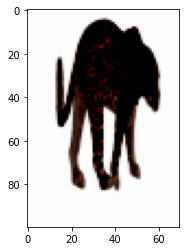

In [77]:
plt.imshow(np.split(X_test[0], 2, axis=2)[0])

### Image 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


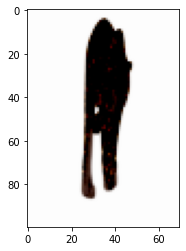

In [78]:
plt.imshow(np.split(X_test[0], 2, axis=2)[1])

### Predicted angle difference

In [93]:
print((np.array(range(-15,16))*3)[(np.argmax(classif_model.predict(X_test)[0]))])

-45


### Actual angle difference

In [106]:
print((np.array(range(-15,16))*3)[(np.argmax((X_test)[0]))])

-45


# 4. Regression network

#### Label values are changed to range [-1,1] for regressor. 
Each floating value corresponds to values -45 to 45.

In [19]:
Y_train_reg = np.round((Y_train/45), decimals=2)
Y_val_reg = np.round((Y_val/45), decimals=2)
Y_test_reg = np.round((Y_test/45), decimals=2)

### Regressor model

In [20]:
reg_model = keras.Sequential([
    keras.layers.Conv2D(16, (2,2), activation='relu', padding='same', input_shape=(100,70,6)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (2,2), activation='relu', padding='same'), 
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(31, activation='relu'),
    keras.layers.Dense(1, activation='linear'),
])

reg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 70, 16)       400       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 35, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 35, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 17, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                421631    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
reg_opt = keras.optimizers.Adam(lr=0.0001)
reg_model.compile(optimizer=reg_opt, loss='mse', metrics=['mse'])
reg_model_history = reg_model.fit(X_train, Y_train_reg, epochs=10,validation_data = (X_val, Y_val_reg))

Epoch 1/10
88/88 [==============================] - 5s 56ms/step - loss: 0.4025 - mse: 0.4025 - val_loss: 0.3303 - val_mse: 0.3303
Epoch 2/10
88/88 [==============================] - 5s 52ms/step - loss: 0.3384 - mse: 0.3384 - val_loss: 0.3031 - val_mse: 0.3031
Epoch 3/10
88/88 [==============================] - 4s 51ms/step - loss: 0.2555 - mse: 0.2555 - val_loss: 0.2425 - val_mse: 0.2425
Epoch 4/10
88/88 [==============================] - 5s 54ms/step - loss: 0.1721 - mse: 0.1721 - val_loss: 0.1468 - val_mse: 0.1468
Epoch 5/10
88/88 [==============================] - 5s 54ms/step - loss: 0.0899 - mse: 0.0899 - val_loss: 0.0658 - val_mse: 0.0658
Epoch 6/10
88/88 [==============================] - 4s 51ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 7/10
88/88 [==============================] - 4s 51ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 8/10
88/88 [==============================] - 5s 53ms/step - loss: 0.0149 - m

### Learning curve

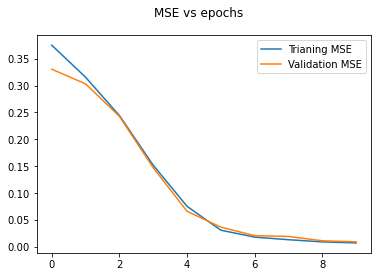

In [22]:
plot_mse(reg_model_history)

In [23]:
reg_test_loss, reg_test_mse = reg_model.evaluate(X_test, Y_test_reg)

20/20 [==============================] - 0s 9ms/step - loss: 0.0100 - mse: 0.0100


In [24]:
print('MSE:')
print('Train MSE :{:.4f}'.format(reg_model_history.history.get('mse')[-1]))
print('Validation MSE :{:.4f}'.format(reg_model_history.history.get('val_mse')[-1]))
print('Test MSE :{:.4f}'.format(reg_test_mse))

MSE:
Train MSE :0.0069
Validation MSE :0.0089
Test MSE :0.0100


## Regression Model - Prediction Example

### Image 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


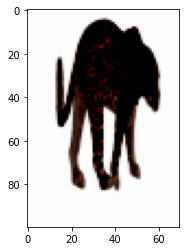

In [99]:
plt.imshow(np.split(X_test[2], 2, axis=2)[0])

### Image 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


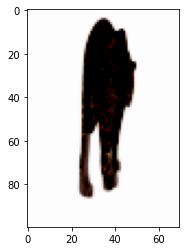

In [100]:
plt.imshow(np.split(X_test[2], 2, axis=2)[1])

### Predicted angle difference

In [105]:
print((np.array(range(-15,16))*3)[(np.argmax(reg_model.predict(X_test)[2]))])

-45


### Actual angle difference

In [104]:
print((np.array(range(-15,16))*3)[(np.argmax((X_test)[2]))])

-45


# 5. Basic Transfer Learning 
### - Using MobileNet V2
##### Gray scale images are used for this part. Once the images are paired, 3rd channel of the paired images are left blank

In [25]:
# Functions to convert RGB images to gray scale and to resize images to square images - 96x96
def gray_scale(img_arr):
    gray_images = []
    for img in range(len(img_arr)):
        gray_images.append(skimage.color.rgb2gray(img_arr[img]))
    gray_images = np.array(gray_images)
    return gray_images

def resize_square(arr):
    rs_img = []
    for img in range(len(arr)):
        rs_img.append(resize(arr[img],(96,96)))
    rs_img = np.array(rs_img)
    return rs_img

#### Resize images to square images

In [26]:
square_images = resize_square(images_norm)
print('Images resized to: {}x{}'.format(square_images.shape[1],square_images.shape[2]))

Images resized to: 96x96


#### Convert images to gray-scale

In [27]:
gray_images = gray_scale(square_images)

#### Function to stack grayscale images in pairs with 3rd channel as blank. A blank image is created and added to the gray scale image pairs to set the 3rd channel of the image pairs blank.

In [28]:
def tl_img_pairs(start_positions,img_arr):
    pairs = []
    labels = []
    # images with blank channel
    blank = np.ones((96,96,1))
    img_offset_values = np.array(range(-15,16))
    for idx in (start_positions):
        for j in range(len(img_offset_values)):
            img1 = img_arr[idx]
            j2 = img_offset_values[j]
            i2 = idx+j2
            if i2 >= 120:
                i2 = i2 % 120
            img2 = img_arr[(i2)]
            s = np.stack((img1, img2), axis=2)
            pairs.append(np.concatenate((s,blank),axis=2))
            labels.append(j2*3)
    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels

### Image pairs and train, validation, test sets split (90:10:20 - Start positions)

In [29]:
X_train_tl, Y_train_tl = tl_img_pairs(train_idx,gray_images)
X_val_tl, Y_val_tl = tl_img_pairs(val_idx,gray_images)
X_test_tl, Y_test_tl = tl_img_pairs(test_idx,gray_images)
print('Total number of pairs:')
print('Train :', len(X_train_tl))
print('Validation:',len(X_val_tl))
print('Tets:',len(X_test_tl))
print('\n')
print('Shape of image pairs:')
print('Train:',X_train_tl.shape)
print('Validation:',X_val_tl.shape)
print('Test:', X_test_tl.shape)

Total number of pairs:
Train : 2790
Validation: 310
Tets: 620


Shape of image pairs:
Train: (2790, 96, 96, 3)
Validation: (310, 96, 96, 3)
Test: (620, 96, 96, 3)


#### Label values are changed to range [-1,1] for regressor. 
Each floating value corresponds to values -45 to 45.

In [30]:
Y_train_tl_norm = np.round((Y_train_tl/45), decimals=2)
Y_val_tl_norm = np.round((Y_val_tl/45), decimals=2)
Y_test_tl_norm = np.round((Y_test_tl/45), decimals=2)

### Model

##### Import MobileNetV2 model with pretrained weights without the head.

In [31]:
mobile_base_model = keras.applications.MobileNetV2(
    input_shape = (96,96,3),
    weights = 'imagenet',
    include_top = False
)

##### Freeze layers in base model

In [32]:
for layer in mobile_base_model.layers:
    layer.trainable = False

##### Additional 73 layers are removed form the top for better performance and training speed. Only 8 blocks of MobileNetV2 are used.

In [33]:
for i in range(73):
    mobile_base_model._layers.pop() 

##### Add layers to the base model

In [34]:
x = mobile_base_model.layers[-1].output
x = keras.layers.Conv2D(16, (1,1), activation='relu', padding='same')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.01)(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dense(1, activation='linear')(x)

tl_model = Model(inputs=mobile_base_model.input, outputs=x)

tl_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [35]:
tl_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
tl_model_history = tl_model.fit(X_train_tl, Y_train_tl_norm, epochs=40, validation_data=(X_val_tl, Y_val_tl_norm))

Epoch 1/40
88/88 [==============================] - 10s 105ms/step - loss: 4.8826 - mse: 4.8826 - val_loss: 0.2568 - val_mse: 0.2568
Epoch 2/40
88/88 [==============================] - 10s 108ms/step - loss: 0.2908 - mse: 0.2908 - val_loss: 0.1675 - val_mse: 0.1675
Epoch 3/40
88/88 [==============================] - 9s 105ms/step - loss: 0.1757 - mse: 0.1757 - val_loss: 0.1615 - val_mse: 0.1615
Epoch 4/40
88/88 [==============================] - 9s 105ms/step - loss: 0.1156 - mse: 0.1156 - val_loss: 0.0854 - val_mse: 0.0854
Epoch 5/40
88/88 [==============================] - 9s 101ms/step - loss: 0.0936 - mse: 0.0936 - val_loss: 0.0803 - val_mse: 0.0803
Epoch 6/40
88/88 [==============================] - 9s 99ms/step - loss: 0.0741 - mse: 0.0741 - val_loss: 0.0802 - val_mse: 0.0802
Epoch 7/40
88/88 [==============================] - 9s 103ms/step - loss: 0.0628 - mse: 0.0628 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 8/40
88/88 [==============================] - 9s 105ms/step - loss: 0

#### Learning curve

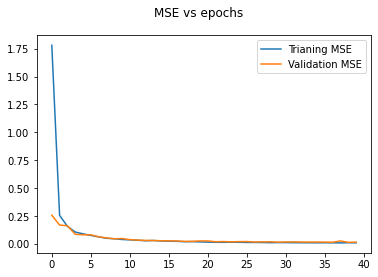

In [36]:
plot_mse(tl_model_history)

In [37]:
tl_test_loss, tl_test_mse = tl_model.evaluate(X_test_tl, Y_test_tl_norm)

20/20 [==============================] - 2s 92ms/step - loss: 0.0179 - mse: 0.0179


In [38]:
print('MSE:')
print('Train MSE :{:.4f}'.format(tl_model_history.history.get('mse')[-1]))
print('Validation MSE :{:.4f}'.format(tl_model_history.history.get('val_mse')[-1]))
print('Test MSE :{:.4f}'.format(tl_test_mse))

MSE:
Train MSE :0.0084
Validation MSE :0.0146
Test MSE :0.0179


### Transfer Learned Model - Prediction Example

### Stacked images - 1 (Light Blue) and 2 (Dark Blue)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


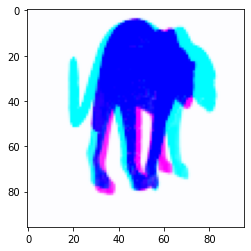

In [111]:
plt.imshow(X_test_tl[7])

### Predicted angle difference

In [126]:
print(np.round((tl_model.predict(X_test_tl)[7])*45))

[-24.]


### Actual angle difference

In [122]:
print(np.round((Y_test_tl_norm[7])*45))

-24.0


# 5.1 Non-sequential model and Fine Tuning
## Siamese network

- Siamese network uses left and right models, which takes two separate images as inputs respectively.
- The features from two models are fused to a layer, after which output layer is added.
- MobileNetV2 is used as feature extractor for left and right models of siamese network.
- RGB images of size 96x96 are used. 
- Left and Right mobilenetV2 models in Siamese network require individual images of a pair, passed into the respective models. First image of the pair into left model and second image of the pair into the right model.

In [39]:
# Resize the normalized RGB images to size 96x96
rs_images = resize_square(images_norm)

In [40]:
# Function to create RGB image pairs to pass into left and right models of siamese network
def image_pairs_siam(starting_positions,img_arr):
    pairs = []
    labels = []
    img_offset_values = np.array(range(-15,16))
    for idx in starting_positions:
        for j in range(len(img_offset_values)):
            img1 = img_arr[idx]
            j2 = img_offset_values[j]
            i2 = idx+j2
            if i2 >= 120:
                i2 = i2 % 120
            img2 = img_arr[i2]            
            pairs.append(np.concatenate((img1,img2),axis=0))
            labels.append(j2*3)
            
    pairs = np.array(pairs)
    image_pairs = pairs.reshape((pairs.shape[0],2,96,96,3))
    
    labels = np.array(labels)
    return image_pairs, labels

### Image pairs and train, validation, test sets split (90:10:20 - Start positions)

In [41]:
siam_train, siam_train_lab = image_pairs_siam(train_idx,rs_images)
siam_val, siam_val_lab = image_pairs_siam(val_idx,rs_images)
siam_test, siam_test_lab = image_pairs_siam(test_idx,rs_images)
print('Total number of pairs:')
print('Train :', len(siam_train))
print('Validation:',len(siam_val))
print('Tets:',len(siam_test))
print('\n')
print('Size of images: {}x{}'.format(siam_train.shape[2],siam_train.shape[3]))
print('\n')
print('Shape of image pairs:')
print('Train:',siam_train.shape)
print('Validation:',siam_val.shape)
print('Test:', siam_test.shape)

Total number of pairs:
Train : 2790
Validation: 310
Tets: 620


Size of images: 96x96


Shape of image pairs:
Train: (2790, 2, 96, 96, 3)
Validation: (310, 2, 96, 96, 3)
Test: (620, 2, 96, 96, 3)


#### Label values are changed to range [-1,1] for regressor. 
Each floating value corresponds to values -45 to 45.

In [42]:
siam_train_norm = np.round((siam_train_lab/45), decimals=2)
siam_val_norm = np.round((siam_val_lab/45), decimals=2)
siam_test_norm = np.round((siam_test_lab/45), decimals=2)

### Mobilenet model for feature extraction (left and right models of siamese network) without the head.

In [43]:
siam_mob_model = keras.applications.MobileNetV2(
    input_shape = (96,96,3),
    weights = 'imagenet',
    include_top = False
)

##### Additional 73 layers are removed form the top for better performance and training speed.

In [44]:
for i in range(73):
    siam_mob_model._layers.pop()

##### All the layers except the top 18 layers are freezed. Top 18 layers are set trainable for fine tuning purpose.

In [45]:
for layer in siam_mob_model.layers[:-18]:
    layer.trainable = False

## Siamese model

In [46]:
siam_input_shape = (96, 96, 3)

siam_left_input = keras.layers.Input(siam_input_shape)
siam_right_input = keras.layers.Input(siam_input_shape)

In [47]:
# left and right models of siamese network
siam_encoded_l = siam_mob_model(siam_left_input)
siam_encoded_r = siam_mob_model(siam_right_input)

In [48]:
# fusion layer - fuses the left and right model's output
fuse_layer = keras.layers.Concatenate()([siam_encoded_l,siam_encoded_r])

x1 = keras.layers.Conv2D(16, (1,1), activation='relu', padding='same')(fuse_layer)
x1 = keras.layers.Flatten()(x1)
x1 = keras.layers.Dense(120, activation='relu')(x1)
x1 = keras.layers.Dense(1, activation='linear')(x1)

siamese_model = Model(inputs=[siam_left_input,siam_right_input],outputs=x1)

In [49]:
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_96 (Functional (None, 3, 3, 1280)   192832      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3, 3, 2560)   0           mobilenetv2_1.00_96[0][0]  

In [50]:
siamese_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
siamese_model_history = siamese_model.fit([siam_train[:,0],siam_train[:,1]], siam_train_norm, epochs=40,
                                      validation_data=([siam_val[:,0], siam_val[:,1]], siam_val_norm))

Epoch 1/40
88/88 [==============================] - 35s 363ms/step - loss: 0.4719 - mse: 0.4719 - val_loss: 0.3044 - val_mse: 0.3044
Epoch 2/40
88/88 [==============================] - 33s 375ms/step - loss: 0.0919 - mse: 0.0919 - val_loss: 0.2759 - val_mse: 0.2759
Epoch 3/40
88/88 [==============================] - 35s 400ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.2169 - val_mse: 0.2169
Epoch 4/40
88/88 [==============================] - 36s 405ms/step - loss: 0.0400 - mse: 0.0400 - val_loss: 0.2041 - val_mse: 0.2041
Epoch 5/40
88/88 [==============================] - 35s 395ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.1756 - val_mse: 0.1756
Epoch 6/40
88/88 [==============================] - 32s 367ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.1571 - val_mse: 0.1571
Epoch 7/40
88/88 [==============================] - 35s 399ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.1173 - val_mse: 0.1173
Epoch 8/40
88/88 [==============================] - 35s 400ms/step - 

#### Learning curve

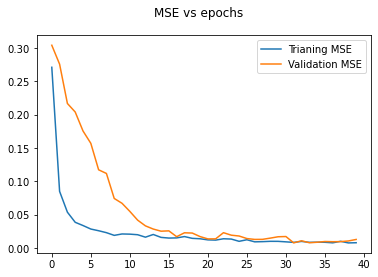

In [51]:
plot_mse(siamese_model_history)

In [52]:
s_test_loss, s_test_mse = siamese_model.evaluate([siam_test[:,0],siam_test[:,1]], siam_test_norm)

20/20 [==============================] - 4s 191ms/step - loss: 0.0129 - mse: 0.0129


In [53]:
print('MSE:')
print('Train MSE :{:.4f}'.format(siamese_model_history.history.get('mse')[-1]))
print('Validation MSE :{:.4f}'.format(siamese_model_history.history.get('val_mse')[-1]))
print('Test MSE :{:.4f}'.format(s_test_mse))

MSE:
Train MSE :0.0078
Validation MSE :0.0127
Test MSE :0.0129


## Siamese model - Prediction example

### Image 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


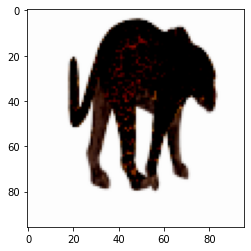

In [136]:
plt.imshow(siam_test[10][0])

### Image 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


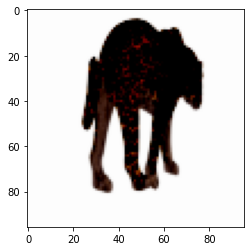

In [135]:
plt.imshow(siam_test[10][1])

### Predicted angle difference

In [133]:
print(np.round((siamese_model.predict([siam_test[:,0],siam_test[:,1]])[10])*45))

[-12.]


### Actual angle difference

In [134]:
print(np.round((siam_test_norm[10])*45))

-15.0
